In [52]:
import hopsworks as hw
import pandas as pd

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
project = hw.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224405
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
wine_fg = fs.get_feature_group(name='wine', version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name='wine',
                                              version=2,
                                              description="Reading from Wine Dataset",
                                              labels=['quality'],
                                              query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/224405/fs/224324/fv/wine/version/2


In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.70s) 


In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4263, 12), (4263, 1), (1066, 12), (1066, 1))

In [15]:
import xgboost as xgb

In [17]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [19]:
y_pred = model.predict(X_test)

In [20]:
mse = mean_squared_error(y_test, y_pred)

In [21]:
mse

0.5596516958612099

In [41]:
import pandas as pd

df = pd.DataFrame({"pred": y_pred.round().astype(int),
                   "gt": y_test.squeeze()})

In [43]:
df['pred'].value_counts()

pred
3    529
2    370
4    146
1     18
5      3
Name: count, dtype: int64

In [44]:
df['gt'].value_counts()

gt
3    475
2    337
4    168
5     40
1     38
0      8
Name: count, dtype: int64

In [53]:
metrics = classification_report(df['pred'], df['gt'], output_dict=True)
metrics

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '1': {'precision': 0.13157894736842105,
  'recall': 0.2777777777777778,
  'f1-score': 0.17857142857142858,
  'support': 18.0},
 '2': {'precision': 0.6468842729970327,
  'recall': 0.5891891891891892,
  'f1-score': 0.6166902404526167,
  'support': 370.0},
 '3': {'precision': 0.6168421052631579,
  'recall': 0.553875236294896,
  'f1-score': 0.5836653386454183,
  'support': 529.0},
 '4': {'precision': 0.3333333333333333,
  'recall': 0.3835616438356164,
  'f1-score': 0.356687898089172,
  'support': 146.0},
 '5': {'precision': 0.025,
  'recall': 0.3333333333333333,
  'f1-score': 0.046511627906976744,
  'support': 3.0},
 'accuracy': 0.5375234521575984,
 'macro avg': {'precision': 0.2922731098269908,
  'recall': 0.3562895300718021,
  'f1-score': 0.29702108894426876,
  'support': 1066.0},
 'weighted avg': {'precision': 0.5785804337827494,
  'recall': 0.5375234521575984,
  'f1-score': 0.5556891246059289,
  'support': 1066.

In [35]:
results = confusion_matrix(y_pred.round(), y_test)
df_cm = pd.DataFrame(results, [f'True {i}' for i in range(3, 9)],
                     [f'Pred {i}' for i in range(3, 9)])

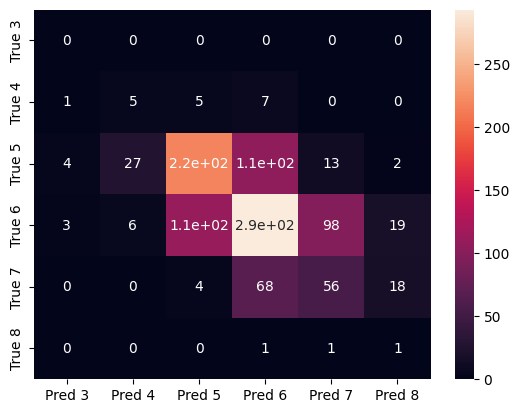

In [51]:
import seaborn as sns
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [54]:
mr = project.get_model_registry()
model_dir = "wine_model"

import joblib

joblib.dump(model, model_dir+'/wine_model.pkl')
fig.savefig(model_dir+'/confusion_matrix.png')

from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy": metrics['accuracy']},
    model_schema=model_schema,
    description="Wine model trained ; mark-I"
)
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 25871/25871 elapsed<00:21 remaining<00:001,  2.75it/s]
Uploading: 100.000%|██████████| 396905/396905 elapsed<00:02 remaining<00:00  2.75it/s]
Uploading: 100.000%|██████████| 1066/1066 elapsed<00:01 remaining<00:000:57, 14.36s/it]
Model export complete: 100%|██████████| 6/6 [00:32<00:00,  5.44s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/224405/models/wine_model/1


Model(name: 'wine_model', version: 1)